<h1> Time Series Forecasting with Deep Learning </h1>
In this notebook we will explore forecasting bitcoin prices with Deep Learning models. 

The notebook will be structured as follows.

1. Analysis Approach
2. Exploratory Data Analysis
3. Data Preparation
4. Model Creation and Training
5. Conclusion


<h2> 1. Analysis Approach </h2>

In this notebook we will look at how different regression techniques can be used to predict bitcoing prices as well as how the different techniques we will use give different results. The data we will use for this exercise is contains OHLCV Bitcoin prices between 2017-01-01 to 2020-02-01 for every 15 minutes. We will start by quickly looking at the dataset, clean if needed, feature engineering followed by building and analyzing results of the different models. We will use and compare 3 different deep learning techniques for time series prediction:

1. Vanilla RNN
2. Vanilla LSTM
3. Vanille GRU

The objective of the analysis will be to compare the accuracy of prediction between the different techniques. Given that bitcoin prices do not actually move so much (in percent) from 15-min to 15-min it might be hard for the models to capture the behavior from just a small data set with little complexity which we will use in this example to limit the training time.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers import Dense
from bokeh.plotting import figure, output_notebook, show
output_notebook()

Loading BokehJS ...

<h2> 2. Exploratory Data Analysis </h2>
We start by importing the dataset. The dataset contains bitcoing price data (OHLC) between 2017-01-01 to 2020-02-01 with an interval of 15 minutes.

Below is a list of the columns in the data set and an explanation:
- Time - <i> Time of observed datapoint </i>
- Open - <i> Open price of the observed time interval </i>
- High - <i> Highest price of the observed time interval </i>
- Low - <i> Lowest price of the observed time interval </i>
- Close - <i> Closing price of the observed time interval </i>
- Volume - <i> Volume of transactions in BTC for the observed time interval </i>

In [2]:
df = pd.read_csv("/Users/jakobwiren/Dropbox/Coding/Bot/Binance_BTCUSDT_20170101.csv")
df['Time'] = pd.to_datetime(df['Time']) #make datetime format

In [3]:
display(df.head())

,Unnamed: 0,Time,Open,High,Low,Close,Volume
0,0,2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061
1,1,2017-08-17 04:15:00,4261.48,4270.41,4261.32,4261.45,9.119865
2,2,2017-08-17 04:30:00,4280.00,4310.07,4267.99,4310.07,21.923552
3,3,2017-08-17 04:45:00,4310.07,4313.62,4291.37,4308.83,13.948531
4,4,2017-08-17 05:00:00,4308.83,4328.69,4304.31,4304.31,5.101153


Looking at the first 5 rows we see that looks fine but we can drop the first column since that is just an imported index column from Excel. Drop first column.

In [4]:
df = df.drop(['Unnamed: 0'], axis = 1)
display(df.head())

,Time,Open,High,Low,Close,Volume
0,2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061
1,2017-08-17 04:15:00,4261.48,4270.41,4261.32,4261.45,9.119865
2,2017-08-17 04:30:00,4280.00,4310.07,4267.99,4310.07,21.923552
3,2017-08-17 04:45:00,4310.07,4313.62,4291.37,4308.83,13.948531
4,2017-08-17 05:00:00,4308.83,4328.69,4304.31,4304.31,5.101153


Let's look at some initial statistics at the data as well as plotting the close price over time. I am using Bokeh to plot the data in an interactive fram which enables me to zoom into different parts of the data as I wish.

In [5]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87289 entries, 0 to 87288
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    87289 non-null  datetime64[ns]
 1   Open    87289 non-null  float64       
 2   High    87289 non-null  float64       
 3   Low     87289 non-null  float64       
 4   Close   87289 non-null  float64       
 5   Volume  87289 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 4.0 MB


,Open,High,Low,Close,Volume
count,87289.000000,87289.000000,87289.000000,87289.000000,87289.000000
mean,7536.241756,7560.807045,7510.383124,7536.268695,364.013618
std,2816.681197,2834.480469,2797.316850,2816.622884,436.838805
min,2830.000000,2880.010000,2817.000000,2820.000000,0.000000
25%,5624.980000,5639.990000,5610.000000,5624.980000,142.351631
50%,7327.480000,7344.950000,7311.000000,7326.900000,256.692541
75%,9208.330000,9231.350000,9180.060000,9209.110000,435.298532
max,19756.000000,19798.680000,19680.200000,19756.020000,10340.338241


In [11]:
f = figure(width=900, height=400, x_axis_type='datetime', x_axis_label = 'Time', y_axis_label = 'Close Price (USD)')
f.line(df['Time'], df['Close'], line_width=2)
show(f)

Looking at the dataset we can see that each column has the same count and no strange deviations in the std, mean, min or max values. The volume column is obviously holding different values compared to the other columns due to the scale of the feature. This will be addressed later on in the workbook, but the conclusion from the first analysis is that the quality of the data is sufficiently good without any missing values or extreme values we need to address before carrying on.

We can see from the chart the Bitcoin had its high at almost 20,000 USD in Dec 2019 and later dropped to below 5,000 to stabalize around 10,000 in the end of 2019. As a first step, let's look at the autocorrelation plot which indicates if correlation exists with previous values. In this case, my hypothesis is that there should be high autocorrelation since previous prices affect the next price.

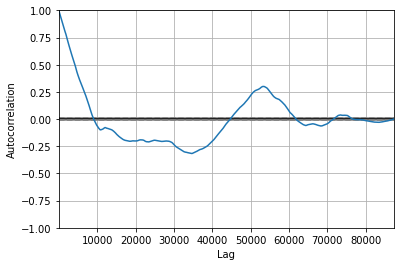

In [12]:
pd.plotting.autocorrelation_plot(df['Close']) 

When plotting the autocorrelation we can see extremely high autocorrelation which makes sense since the next price will always be very very similiar to the previous one, the previous one before that and so on. We can therefore accept the hypothesis.

To further support the exploratory analysis we generate a pairplot to review potential correlations as well as the distribution for each feature.

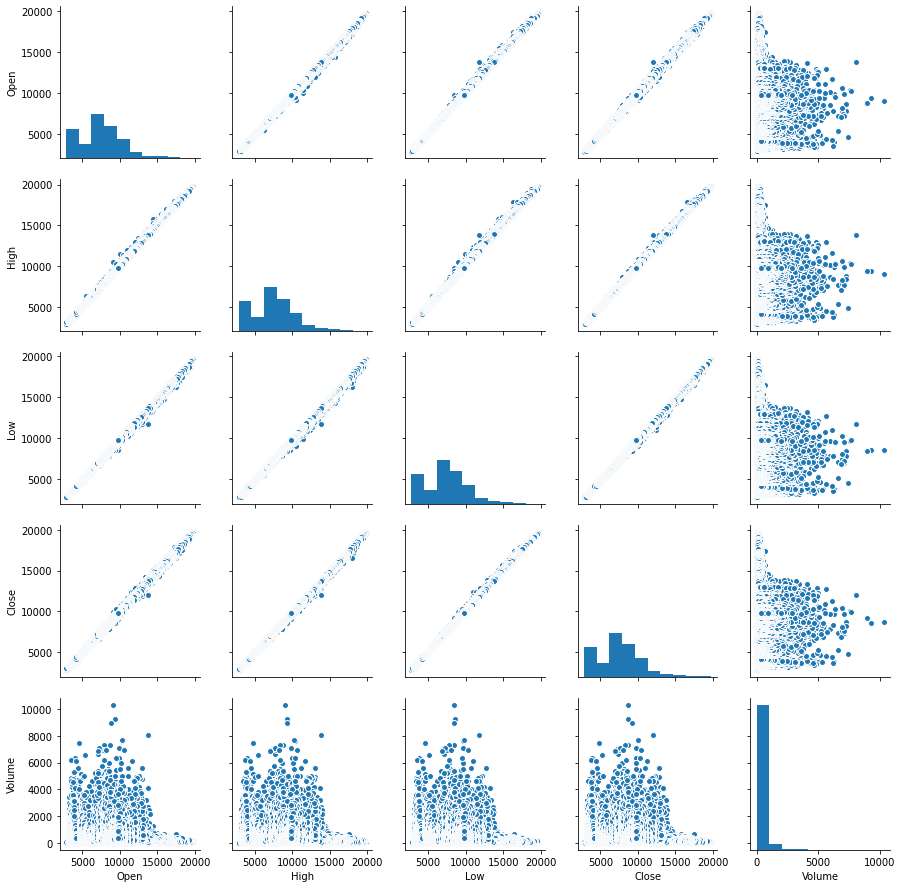

In [13]:
sns.pairplot(df)

By looking at the pairplot we can see that the price features visualize as a diagonal line, indicating strong correlations. This of course makes sense since opening, close, high and lowest price are highly very similiar to each other. We can also confirm that we have no significant outliers.

The dataset is good to contine being prepared for generating predictive models.

<h2> 3. Data preparation and Feature Creation </h2>
In order to create the models and train them we need to arrange the data into sequences. We will only use the "close" column as our feature since it will automatically create features by the lags we do not need specify those features like we do for e.g. a Random Forest.

In [6]:
def get_n_last_days(df, series_name, n_days):
    
    return df[series_name][-(24*4*n_days):] #we have data from every 15 min
def get_keras_format_series(series):


    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1) #convert to (n_samples, time_steps , features)

def get_train_test_data(df, columns, no_days, seq_len, 
                        test_len):
  
    
    forecast_series = get_n_last_days(df, columns, no_days).values # reducing our forecast series to last n days

    train = forecast_series[:-test_len] # training data is remaining days until amount of test_hours
    test = forecast_series[-test_len:] # test data is the remaining test_hours

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-seq_len): 
        train_X.append(train[i:i+seq_len]) # each training sample is of length input hours
        train_y.append(train[i+seq_len]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:seq_len] 
    test_y = test[seq_len:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

<h2> 4. Model Creation and Training </h2>

As mentioned we will create 3 models to compare with:

1. Vanilla RNN
2. Vanilla LSTM
3. Vanilla GRU

Let's first decide what input values we will use in our models. We will train our model on 30 days, each sequence will have a lenght of 1 day and the test length will be 2 days.

In [19]:
columns = 'Close'
no_days = 60
seq_len = 24*4*7 #1 day
test_len = 48*4*7 #2 days

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df, columns, no_days, 
                         seq_len, test_len))

In [20]:
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (3744, 672, 1)
Training output shape: (3744,)
Test input shape: (672,)
Test output shape: (672,)


<h3> 4.1. Vanilla RNN </h3>

Let's create our Vanilla RNN model.

In [136]:
# initialize model
model = Sequential() 

#add simple RNN layer
model.add(SimpleRNN(50, input_shape=(train_X.shape[1],1)))

# add an output layer 
model.add(Dense(1))

# define the loss function / optimization strategy
model.compile(loss='mean_squared_error', optimizer='adam', metrics ='accuracy')

#
model.fit(train_X, train_y, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
41/41 [==============================] - 1s 25ms/step - loss: 86707440.0000 - accuracy: 0.0000e+00
Epoch 2/10
41/41 [==============================] - 1s 25ms/step - loss: 86668496.0000 - accuracy: 0.0000e+00
Epoch 3/10
41/41 [==============================] - 1s 26ms/step - loss: 86629664.0000 - accuracy: 0.0000e+00
Epoch 4/10
41/41 [==============================] - 1s 25ms/step - loss: 86590824.0000 - accuracy: 0.0000e+00
Epoch 5/10
41/41 [==============================] - 1s 26ms/step - loss: 86552016.0000 - accuracy: 0.0000e+00
Epoch 6/10
41/41 [==============================] - 1s 26ms/step - loss: 86513208.0000 - accuracy: 0.0000e+00
Epoch 7/10
41/41 [==============================] - 1s 25ms/step - loss: 86474424.0000 - accuracy: 0.0000e+00
Epoch 8/10
41/41 [==============================] - 1s 25ms/step - loss: 86435656.0000 - accuracy: 0.0000e+00
Epoch 9/10
41/41 [==============================] - 1s 26ms/step - loss: 86396880.0000 - accuracy: 0.0000e+00
Epoch 10/1

From the results we can see that the Vanilla RNN does not generate any good results. The MSE and Accuracy is high, nevertheless we can see that the MSE decreases for every epoch. The model is probably underfitting highly since we are not using so much data nor epochs to train the model. Let's try a vanilla LSTM to see if there is any difference.

<h3> 4.3 Vanilla LSTM

In [137]:
# initialize model
model = Sequential() 

#add simple RNN layer
model.add(LSTM(50, input_shape=(train_X.shape[1],1)))

# add an output layer 
model.add(Dense(1))

# define the loss function / optimization strategy
model.compile(loss='mean_squared_error', optimizer='adam', metrics ='accuracy')

#
model.fit(train_X, train_y, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
41/41 [==============================] - 3s 68ms/step - loss: 86684160.0000 - accuracy: 0.0000e+00
Epoch 2/10
41/41 [==============================] - 3s 69ms/step - loss: 86676248.0000 - accuracy: 0.0000e+00
Epoch 3/10
41/41 [==============================] - 3s 65ms/step - loss: 86668424.0000 - accuracy: 0.0000e+00
Epoch 4/10
41/41 [==============================] - 3s 70ms/step - loss: 86660584.0000 - accuracy: 0.0000e+00
Epoch 5/10
41/41 [==============================] - 3s 65ms/step - loss: 86652760.0000 - accuracy: 0.0000e+00
Epoch 6/10
41/41 [==============================] - 3s 67ms/step - loss: 86644928.0000 - accuracy: 0.0000e+00
Epoch 7/10
41/41 [==============================] - 3s 66ms/step - loss: 86637072.0000 - accuracy: 0.0000e+00
Epoch 8/10
41/41 [==============================] - 3s 64ms/step - loss: 86629264.0000 - accuracy: 0.0000e+00
Epoch 9/10
41/41 [==============================] - 3s 63ms/step - loss: 86621416.0000 - accuracy: 0.0000e+00
Epoch 10/1

Again we can see that the LSTM performs rather poorly, actually even worse than the simple RNN. Let's try running a few more epochs to see if it makes any difference.

In [142]:
model.fit(train_X, train_y, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
41/41 [==============================] - 3s 64ms/step - loss: 86605760.0000 - accuracy: 0.0000e+00
Epoch 2/100
41/41 [==============================] - 3s 76ms/step - loss: 86597920.0000 - accuracy: 0.0000e+00
Epoch 3/100
41/41 [==============================] - 3s 82ms/step - loss: 86590080.0000 - accuracy: 0.0000e+00
Epoch 4/100
41/41 [==============================] - 3s 72ms/step - loss: 86582272.0000 - accuracy: 0.0000e+00
Epoch 5/100
41/41 [==============================] - 3s 68ms/step - loss: 86574440.0000 - accuracy: 0.0000e+00
Epoch 6/100
41/41 [==============================] - 3s 69ms/step - loss: 86566616.0000 - accuracy: 0.0000e+00
Epoch 7/100
41/41 [==============================] - 3s 74ms/step - loss: 86558792.0000 - accuracy: 0.0000e+00
Epoch 8/100
41/41 [==============================] - 3s 64ms/step - loss: 86550960.0000 - accuracy: 0.0000e+00
Epoch 9/100
41/41 [==============================] - 3s 65ms/step - loss: 86543144.0000 - accuracy: 0.0000e+00
E

Even after running 10x more epochs we see that the model is performing poorly, probably it requires lot of training before it learns the behaviors. Let's try increasing the number of epochs drastically.

In [116]:
model.fit(train_X, train_y, epochs = 3000, batch_size = 64, 
                      verbose = 1)

Epoch 1/3000
14/14 [==============================] - 1s 69ms/step - loss: 86701584.0000
Epoch 2/3000
14/14 [==============================] - 1s 72ms/step - loss: 86698240.0000
Epoch 3/3000
14/14 [==============================] - 1s 71ms/step - loss: 86694904.0000
Epoch 4/3000
14/14 [==============================] - 1s 72ms/step - loss: 86691552.0000
Epoch 5/3000
14/14 [==============================] - 1s 72ms/step - loss: 86688208.0000
Epoch 6/3000
14/14 [==============================] - 1s 75ms/step - loss: 86684872.0000
Epoch 7/3000
14/14 [==============================] - 1s 72ms/step - loss: 86681528.0000
Epoch 8/3000
14/14 [==============================] - 1s 72ms/step - loss: 86678184.0000
Epoch 9/3000
14/14 [==============================] - 1s 73ms/step - loss: 86674848.0000
Epoch 10/3000
14/14 [==============================] - 1s 83ms/step - loss: 86671496.0000
Epoch 11/3000
14/14 [==============================] - 1s 74ms/step - loss: 86668152.0000
Epoch 12/3000
14/14

14/14 [==============================] - 2s 119ms/step - loss: 86397656.0000
Epoch 93/3000
14/14 [==============================] - 2s 111ms/step - loss: 86394320.0000
Epoch 94/3000
14/14 [==============================] - 1s 106ms/step - loss: 86390992.0000
Epoch 95/3000
14/14 [==============================] - 2s 128ms/step - loss: 86387648.0000
Epoch 96/3000
14/14 [==============================] - 2s 117ms/step - loss: 86384328.0000
Epoch 97/3000
14/14 [==============================] - 1s 69ms/step - loss: 86380984.0000
Epoch 98/3000
14/14 [==============================] - 1s 68ms/step - loss: 86377656.0000
Epoch 99/3000
14/14 [==============================] - 1s 71ms/step - loss: 86374312.0000
Epoch 100/3000
14/14 [==============================] - 1s 69ms/step - loss: 86370968.0000
Epoch 101/3000
14/14 [==============================] - 1s 69ms/step - loss: 86367648.0000
Epoch 102/3000
14/14 [==============================] - 1s 69ms/step - loss: 86364304.0000
Epoch 103/3000
1

14/14 [==============================] - 1s 89ms/step - loss: 86097760.0000
Epoch 183/3000
14/14 [==============================] - 1s 88ms/step - loss: 86094424.0000
Epoch 184/3000
14/14 [==============================] - 1s 99ms/step - loss: 86091104.0000
Epoch 185/3000
14/14 [==============================] - 1s 88ms/step - loss: 86087768.0000
Epoch 186/3000
14/14 [==============================] - 1s 78ms/step - loss: 86084448.0000
Epoch 187/3000
14/14 [==============================] - 1s 76ms/step - loss: 86081120.0000
Epoch 188/3000
14/14 [==============================] - 1s 79ms/step - loss: 86077792.0000
Epoch 189/3000
14/14 [==============================] - 1s 82ms/step - loss: 86074464.0000
Epoch 190/3000
14/14 [==============================] - 2s 128ms/step - loss: 86071128.0000
Epoch 191/3000
14/14 [==============================] - 2s 132ms/step - loss: 86067808.0000
Epoch 192/3000
14/14 [==============================] - 1s 104ms/step - loss: 86064472.0000
Epoch 193/3

14/14 [==============================] - 2s 116ms/step - loss: 85798448.0000
Epoch 273/3000
14/14 [==============================] - 2s 125ms/step - loss: 85795136.0000
Epoch 274/3000
14/14 [==============================] - 2s 155ms/step - loss: 85791800.0000
Epoch 275/3000
14/14 [==============================] - 2s 109ms/step - loss: 85788480.0000
Epoch 276/3000
14/14 [==============================] - 2s 123ms/step - loss: 85785160.0000
Epoch 277/3000
14/14 [==============================] - 1s 102ms/step - loss: 85781832.0000
Epoch 278/3000
14/14 [==============================] - 1s 77ms/step - loss: 85778504.0000
Epoch 279/3000
14/14 [==============================] - 1s 77ms/step - loss: 85775192.0000
Epoch 280/3000
14/14 [==============================] - 1s 102ms/step - loss: 85771872.0000
Epoch 281/3000
14/14 [==============================] - 2s 126ms/step - loss: 85768560.0000
Epoch 282/3000
14/14 [==============================] - 2s 142ms/step - loss: 85765232.0000
Epoch

14/14 [==============================] - 1s 89ms/step - loss: 85208112.0000
Epoch 451/3000
14/14 [==============================] - 1s 79ms/step - loss: 85204808.0000
Epoch 452/3000
14/14 [==============================] - 1s 76ms/step - loss: 85201496.0000
Epoch 453/3000
14/14 [==============================] - 1s 82ms/step - loss: 85198184.0000
Epoch 454/3000
14/14 [==============================] - 1s 75ms/step - loss: 85194872.0000
Epoch 455/3000
14/14 [==============================] - 1s 79ms/step - loss: 85191568.0000
Epoch 456/3000
14/14 [==============================] - 1s 81ms/step - loss: 85188256.0000
Epoch 457/3000
14/14 [==============================] - 1s 79ms/step - loss: 85184936.0000
Epoch 458/3000
14/14 [==============================] - 1s 68ms/step - loss: 85181632.0000
Epoch 459/3000
14/14 [==============================] - 1s 70ms/step - loss: 85178320.0000
Epoch 460/3000
14/14 [==============================] - 1s 70ms/step - loss: 85175008.0000
Epoch 461/3000

14/14 [==============================] - 1s 66ms/step - loss: 84910432.0000
Epoch 541/3000
14/14 [==============================] - 1s 69ms/step - loss: 84907128.0000
Epoch 542/3000
14/14 [==============================] - 1s 67ms/step - loss: 84903824.0000
Epoch 543/3000
14/14 [==============================] - 1s 69ms/step - loss: 84900520.0000
Epoch 544/3000
14/14 [==============================] - 1s 67ms/step - loss: 84897224.0000
Epoch 545/3000
14/14 [==============================] - 1s 66ms/step - loss: 84893896.0000
Epoch 546/3000
14/14 [==============================] - 1s 69ms/step - loss: 84890592.0000
Epoch 547/3000
14/14 [==============================] - 1s 66ms/step - loss: 84887304.0000
Epoch 548/3000
14/14 [==============================] - 1s 67ms/step - loss: 84884000.0000
Epoch 549/3000
14/14 [==============================] - 1s 69ms/step - loss: 84880688.0000
Epoch 550/3000
14/14 [==============================] - 1s 68ms/step - loss: 84877376.0000
Epoch 551/3000

14/14 [==============================] - 1s 70ms/step - loss: 84316608.0000
Epoch 721/3000
14/14 [==============================] - 1s 67ms/step - loss: 84313296.0000
Epoch 722/3000
14/14 [==============================] - 1s 67ms/step - loss: 84310008.0000
Epoch 723/3000
14/14 [==============================] - 1s 66ms/step - loss: 84306720.0000
Epoch 724/3000
14/14 [==============================] - 1s 66ms/step - loss: 84303432.0000
Epoch 725/3000
14/14 [==============================] - 1s 67ms/step - loss: 84300136.0000
Epoch 726/3000
14/14 [==============================] - 1s 67ms/step - loss: 84296840.0000
Epoch 727/3000
14/14 [==============================] - 1s 68ms/step - loss: 84293568.0000
Epoch 728/3000
14/14 [==============================] - 1s 66ms/step - loss: 84290264.0000
Epoch 729/3000
14/14 [==============================] - 1s 67ms/step - loss: 84286984.0000
Epoch 730/3000
14/14 [==============================] - 1s 66ms/step - loss: 84283688.0000
Epoch 731/3000

14/14 [==============================] - 1s 92ms/step - loss: 83724912.0000
Epoch 901/3000
14/14 [==============================] - 1s 79ms/step - loss: 83721624.0000
Epoch 902/3000
14/14 [==============================] - 1s 77ms/step - loss: 83718344.0000
Epoch 903/3000
14/14 [==============================] - 1s 78ms/step - loss: 83715064.0000
Epoch 904/3000
14/14 [==============================] - 1s 78ms/step - loss: 83711792.0000
Epoch 905/3000
14/14 [==============================] - 1s 78ms/step - loss: 83708504.0000
Epoch 906/3000
14/14 [==============================] - 1s 78ms/step - loss: 83705232.0000
Epoch 907/3000
14/14 [==============================] - 1s 71ms/step - loss: 83701952.0000
Epoch 908/3000
14/14 [==============================] - 1s 70ms/step - loss: 83698656.0000
Epoch 909/3000
14/14 [==============================] - 1s 68ms/step - loss: 83695376.0000
Epoch 910/3000
14/14 [==============================] - 1s 69ms/step - loss: 83692088.0000
Epoch 911/3000

14/14 [==============================] - 1s 71ms/step - loss: 83138576.0000
Epoch 1080/3000
14/14 [==============================] - 1s 69ms/step - loss: 83135304.0000
Epoch 1081/3000
14/14 [==============================] - 1s 67ms/step - loss: 83132040.0000
Epoch 1082/3000
14/14 [==============================] - 1s 70ms/step - loss: 83128776.0000
Epoch 1083/3000
14/14 [==============================] - 1s 72ms/step - loss: 83125504.0000
Epoch 1084/3000
14/14 [==============================] - 1s 69ms/step - loss: 83122232.0000
Epoch 1085/3000
14/14 [==============================] - 1s 72ms/step - loss: 83118960.0000
Epoch 1086/3000
14/14 [==============================] - 1s 69ms/step - loss: 83115688.0000
Epoch 1087/3000
14/14 [==============================] - 1s 71ms/step - loss: 83112416.0000
Epoch 1088/3000
14/14 [==============================] - 1s 70ms/step - loss: 83109160.0000
Epoch 1089/3000
14/14 [==============================] - 1s 70ms/step - loss: 83105888.0000
Epoc

14/14 [==============================] - 1s 65ms/step - loss: 82557576.0000
Epoch 1258/3000
14/14 [==============================] - 1s 67ms/step - loss: 82554312.0000
Epoch 1259/3000
14/14 [==============================] - 1s 67ms/step - loss: 82551056.0000
Epoch 1260/3000
14/14 [==============================] - 1s 64ms/step - loss: 82547800.0000
Epoch 1261/3000
14/14 [==============================] - 1s 69ms/step - loss: 82544544.0000
Epoch 1262/3000
14/14 [==============================] - 1s 66ms/step - loss: 82541280.0000
Epoch 1263/3000
14/14 [==============================] - 1s 65ms/step - loss: 82538024.0000
Epoch 1264/3000
14/14 [==============================] - 1s 71ms/step - loss: 82534768.0000
Epoch 1265/3000
14/14 [==============================] - 1s 67ms/step - loss: 82531512.0000
Epoch 1266/3000
14/14 [==============================] - 1s 67ms/step - loss: 82528248.0000
Epoch 1267/3000
14/14 [==============================] - 1s 68ms/step - loss: 82524992.0000
Epoc

14/14 [==============================] - 1s 66ms/step - loss: 81978592.0000
Epoch 1436/3000
14/14 [==============================] - 1s 66ms/step - loss: 81975344.0000
Epoch 1437/3000
14/14 [==============================] - 1s 68ms/step - loss: 81972088.0000
Epoch 1438/3000
14/14 [==============================] - 1s 68ms/step - loss: 81968848.0000
Epoch 1439/3000
14/14 [==============================] - 1s 67ms/step - loss: 81965608.0000
Epoch 1440/3000
14/14 [==============================] - 1s 69ms/step - loss: 81962360.0000
Epoch 1441/3000
14/14 [==============================] - 1s 71ms/step - loss: 81959120.0000
Epoch 1442/3000
14/14 [==============================] - 1s 71ms/step - loss: 81955872.0000
Epoch 1443/3000
14/14 [==============================] - 1s 67ms/step - loss: 81952624.0000
Epoch 1444/3000
14/14 [==============================] - 1s 65ms/step - loss: 81949384.0000
Epoch 1445/3000
14/14 [==============================] - 1s 69ms/step - loss: 81946128.0000
Epoc

14/14 [==============================] - 1s 65ms/step - loss: 81404920.0000
Epoch 1613/3000
14/14 [==============================] - 1s 84ms/step - loss: 81401688.0000
Epoch 1614/3000
14/14 [==============================] - 1s 71ms/step - loss: 81398456.0000
Epoch 1615/3000
14/14 [==============================] - 1s 67ms/step - loss: 81395216.0000
Epoch 1616/3000
14/14 [==============================] - 1s 68ms/step - loss: 81391976.0000
Epoch 1617/3000
14/14 [==============================] - 1s 68ms/step - loss: 81388752.0000
Epoch 1618/3000
14/14 [==============================] - 1s 67ms/step - loss: 81385520.0000
Epoch 1619/3000
14/14 [==============================] - 1s 66ms/step - loss: 81382280.0000
Epoch 1620/3000
14/14 [==============================] - 1s 67ms/step - loss: 81379056.0000
Epoch 1621/3000
14/14 [==============================] - 1s 67ms/step - loss: 81375816.0000
Epoch 1622/3000
14/14 [==============================] - 1s 68ms/step - loss: 81372568.0000
Epoc

14/14 [==============================] - 1s 67ms/step - loss: 80830048.0000
Epoch 1791/3000
14/14 [==============================] - 1s 73ms/step - loss: 80826824.0000
Epoch 1792/3000
14/14 [==============================] - 1s 69ms/step - loss: 80823600.0000
Epoch 1793/3000
14/14 [==============================] - 1s 69ms/step - loss: 80820376.0000
Epoch 1794/3000
14/14 [==============================] - 1s 67ms/step - loss: 80817160.0000
Epoch 1795/3000
14/14 [==============================] - 1s 66ms/step - loss: 80813928.0000
Epoch 1796/3000
14/14 [==============================] - 1s 74ms/step - loss: 80810704.0000
Epoch 1797/3000
14/14 [==============================] - 1s 74ms/step - loss: 80807480.0000
Epoch 1798/3000
14/14 [==============================] - 1s 77ms/step - loss: 80804256.0000
Epoch 1799/3000
14/14 [==============================] - 1s 73ms/step - loss: 80801040.0000
Epoch 1800/3000
14/14 [==============================] - 1s 78ms/step - loss: 80797808.0000
Epoc

14/14 [==============================] - 1s 67ms/step - loss: 80257232.0000
Epoch 1969/3000
14/14 [==============================] - 1s 67ms/step - loss: 80254016.0000
Epoch 1970/3000
14/14 [==============================] - 1s 66ms/step - loss: 80250816.0000
Epoch 1971/3000
14/14 [==============================] - 1s 68ms/step - loss: 80247600.0000
Epoch 1972/3000
14/14 [==============================] - 1s 68ms/step - loss: 80244384.0000
Epoch 1973/3000
14/14 [==============================] - 1s 66ms/step - loss: 80241168.0000
Epoch 1974/3000
14/14 [==============================] - 1s 65ms/step - loss: 80237960.0000
Epoch 1975/3000
14/14 [==============================] - 1s 67ms/step - loss: 80234752.0000
Epoch 1976/3000
14/14 [==============================] - 1s 66ms/step - loss: 80231528.0000
Epoch 1977/3000
14/14 [==============================] - 1s 68ms/step - loss: 80228320.0000
Epoch 1978/3000
14/14 [==============================] - 1s 67ms/step - loss: 80225096.0000
Epoc

14/14 [==============================] - 1s 68ms/step - loss: 79686464.0000
Epoch 2147/3000
14/14 [==============================] - 1s 69ms/step - loss: 79683264.0000
Epoch 2148/3000
14/14 [==============================] - 1s 68ms/step - loss: 79680064.0000
Epoch 2149/3000
14/14 [==============================] - 1s 68ms/step - loss: 79676872.0000
Epoch 2150/3000
14/14 [==============================] - 1s 67ms/step - loss: 79673664.0000
Epoch 2151/3000
14/14 [==============================] - 1s 67ms/step - loss: 79670472.0000
Epoch 2152/3000
14/14 [==============================] - 1s 71ms/step - loss: 79667272.0000
Epoch 2153/3000
14/14 [==============================] - 1s 73ms/step - loss: 79664072.0000
Epoch 2154/3000
14/14 [==============================] - 1s 69ms/step - loss: 79660864.0000
Epoch 2155/3000
14/14 [==============================] - 1s 65ms/step - loss: 79657664.0000
Epoch 2156/3000
14/14 [==============================] - 1s 69ms/step - loss: 79654456.0000
Epoc

14/14 [==============================] - 1s 66ms/step - loss: 79117736.0000
Epoch 2325/3000
14/14 [==============================] - 1s 67ms/step - loss: 79114544.0000
Epoch 2326/3000
14/14 [==============================] - 1s 68ms/step - loss: 79111360.0000
Epoch 2327/3000
14/14 [==============================] - 1s 68ms/step - loss: 79108152.0000
Epoch 2328/3000
14/14 [==============================] - 1s 65ms/step - loss: 79104968.0000
Epoch 2329/3000
14/14 [==============================] - 1s 65ms/step - loss: 79101784.0000
Epoch 2330/3000
14/14 [==============================] - 1s 75ms/step - loss: 79098584.0000
Epoch 2331/3000
14/14 [==============================] - 1s 67ms/step - loss: 79095400.0000
Epoch 2332/3000
14/14 [==============================] - 1s 68ms/step - loss: 79092224.0000
Epoch 2333/3000
14/14 [==============================] - 1s 69ms/step - loss: 79089032.0000
Epoch 2334/3000
14/14 [==============================] - 1s 69ms/step - loss: 79085840.0000
Epoc

14/14 [==============================] - 1s 65ms/step - loss: 78550976.0000
Epoch 2503/3000
14/14 [==============================] - 1s 66ms/step - loss: 78547792.0000
Epoch 2504/3000
14/14 [==============================] - 1s 67ms/step - loss: 78544608.0000
Epoch 2505/3000
14/14 [==============================] - 1s 68ms/step - loss: 78541432.0000
Epoch 2506/3000
14/14 [==============================] - 1s 64ms/step - loss: 78538256.0000
Epoch 2507/3000
14/14 [==============================] - 1s 69ms/step - loss: 78535080.0000
Epoch 2508/3000
14/14 [==============================] - 1s 65ms/step - loss: 78531904.0000
Epoch 2509/3000
14/14 [==============================] - 1s 65ms/step - loss: 78528720.0000
Epoch 2510/3000
14/14 [==============================] - 1s 67ms/step - loss: 78525552.0000
Epoch 2511/3000
14/14 [==============================] - 1s 66ms/step - loss: 78522360.0000
Epoch 2512/3000
14/14 [==============================] - 1s 67ms/step - loss: 78519184.0000
Epoc

14/14 [==============================] - 1s 68ms/step - loss: 77986240.0000
Epoch 2681/3000
14/14 [==============================] - 1s 68ms/step - loss: 77983080.0000
Epoch 2682/3000
14/14 [==============================] - 1s 67ms/step - loss: 77979912.0000
Epoch 2683/3000
14/14 [==============================] - 1s 67ms/step - loss: 77976752.0000
Epoch 2684/3000
14/14 [==============================] - 1s 68ms/step - loss: 77973576.0000
Epoch 2685/3000
14/14 [==============================] - 1s 67ms/step - loss: 77970408.0000
Epoch 2686/3000
14/14 [==============================] - 1s 67ms/step - loss: 77967240.0000
Epoch 2687/3000
14/14 [==============================] - 1s 67ms/step - loss: 77964088.0000
Epoch 2688/3000
14/14 [==============================] - 1s 69ms/step - loss: 77960904.0000
Epoch 2689/3000
14/14 [==============================] - 1s 69ms/step - loss: 77957744.0000
Epoch 2690/3000
14/14 [==============================] - 1s 68ms/step - loss: 77954576.0000
Epoc

14/14 [==============================] - 1s 67ms/step - loss: 77423552.0000
Epoch 2859/3000
14/14 [==============================] - 1s 68ms/step - loss: 77420392.0000
Epoch 2860/3000
14/14 [==============================] - 1s 67ms/step - loss: 77417240.0000
Epoch 2861/3000
14/14 [==============================] - 1s 68ms/step - loss: 77414088.0000
Epoch 2862/3000
14/14 [==============================] - 1s 66ms/step - loss: 77410928.0000
Epoch 2863/3000
14/14 [==============================] - 1s 64ms/step - loss: 77407784.0000
Epoch 2864/3000
14/14 [==============================] - 1s 66ms/step - loss: 77404624.0000
Epoch 2865/3000
14/14 [==============================] - 1s 64ms/step - loss: 77401464.0000
Epoch 2866/3000
14/14 [==============================] - 1s 67ms/step - loss: 77398312.0000
Epoch 2867/3000
14/14 [==============================] - 1s 68ms/step - loss: 77395160.0000
Epoch 2868/3000
14/14 [==============================] - 1s 70ms/step - loss: 77392008.0000
Epoc

Even after 3000 epochs we can see that the model is still underfitting significantly. However we can see that the loss is decreasing quite a lot at least. Either I am doing something wrong or we need to add more complexity and train this for a looong time...

<h3> 4.3 Vanilla GRU </h3>

In [24]:
 # initialize model
model_GRU = Sequential() 

#add simple RNN layer
model_GRU.add(GRU(50, input_shape=(train_X.shape[1],1), return_sequences=True))

model_GRU.add(GRU(70, return_sequences = True))

model_GRU.add(GRU(30))

# add an output layer 
model_GRU.add(Dense(1))

# define the loss function / optimization strategy
model_GRU.compile(loss='mean_squared_error', optimizer='adam', metrics ='accuracy')

#fit the model
model_GRU.fit(train_X, train_y, epochs=300, batch_size=100, verbose=1)

Epoch 1/300
38/38 [==============================] - 73s 2s/step - loss: 67823128.0000 - accuracy: 0.0000e+00
Epoch 2/300
38/38 [==============================] - 62s 2s/step - loss: 67764616.0000 - accuracy: 0.0000e+00
Epoch 3/300
38/38 [==============================] - 63s 2s/step - loss: 67742448.0000 - accuracy: 0.0000e+00
Epoch 4/300
38/38 [==============================] - 63s 2s/step - loss: 67721496.0000 - accuracy: 0.0000e+00
Epoch 5/300
38/38 [==============================] - 64s 2s/step - loss: 67701056.0000 - accuracy: 0.0000e+00
Epoch 6/300
38/38 [==============================] - 60s 2s/step - loss: 67680880.0000 - accuracy: 0.0000e+00
Epoch 7/300
38/38 [==============================] - 68s 2s/step - loss: 67660888.0000 - accuracy: 0.0000e+00
Epoch 8/300
38/38 [==============================] - 60s 2s/step - loss: 67641024.0000 - accuracy: 0.0000e+00
Epoch 9/300
38/38 [==============================] - 64s 2s/step - loss: 67621240.0000 - accuracy: 0.0000e+00
Epoch 10/3

38/38 [==============================] - 56s 1s/step - loss: 66369988.0000 - accuracy: 0.0000e+00
Epoch 75/300
38/38 [==============================] - 56s 1s/step - loss: 66350936.0000 - accuracy: 0.0000e+00
Epoch 76/300
38/38 [==============================] - 57s 1s/step - loss: 66331872.0000 - accuracy: 0.0000e+00
Epoch 77/300
38/38 [==============================] - 57s 2s/step - loss: 66312824.0000 - accuracy: 0.0000e+00
Epoch 78/300
10/38 [======>.......................] - ETA: 50s - loss: 65875896.0000 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [15]:
GRU?

Using the GRU model we can see it performed slightly better than the LSTM for 10 epochs but the RNN network still beat it. I think it is clear to say here again it requires some more training and complexity. I think the reason why the RNN is performing better is that we are using too short sequences of data, probably we should use longer sequences to test if that separates the performance for the LSTM/GRU and RNN which has a "long-term" memory.

<h2> 5. Conclusion </h2>

To summarize this notebook we have tried implementing 3 different types of Vanilla Neural Networks on bitcoin time series data. We concluded that for the training data, all 3 methods performed very poorly. For this case, the RNN model performed best at running 10 epochs. However, the reason for this might be that we did not use long enough sequences to achieve the benefit of the external memory of the LSTM/GRU model. Even if the RNN performed best in this case, we have not conducted sufficient testing to recommend that model. Consequently I recommend following list of next steps to explore the methods more:

1. Elaborate with the length of sequences
2. Elaborate with training more epochs
3. Try how different batch sizes impact the model
4. Add complexity by adding more layers to the models
5. Explore adding more features such as the high, low and open price